In [1]:
%run init_notebook.py

In [2]:
import pandas as pd
import numpy as np

In [3]:
from settings import RAW_DATA_DIR, WORK_DATA_DIR, OUT_DATA_DIR, OUT_MODEL_DIR, random_state
from utils.utils import *
from utils.load import load_data, save_file, save_model
from utils.cast_data import apply_datetime_format, check_datetime_sanity, check_singularity_of_values
from utils.plotting import *
from src.src import *

In [4]:
# load data
df_all = load_data(file_name="merged_data.csv", file_path=WORK_DATA_DIR)
data_dict = load_data(file_name="merged_data_dict.pkl", file_path=WORK_DATA_DIR)

df_w = df_all.copy()

In [5]:
# Load data
predicted = "sp_close_lead1"

year_start = 2020
year_end = 2021
year_spread = f'years{year_end}_{year_start}'

In [6]:
# training on X years
df_w = df_w[(df_w["date"] >= dt.datetime(year=year_start, month=1, day=1).date())
            &(df_w["date"] <= dt.datetime(year=year_end, month=12, day=31).date())]
print(f'data compromises {year_end - year_start + 1} years: {df_w.shape[0]} lines')

data compromises 2 years: 504 lines


In [7]:
data_dict["model_features"].update(predicted=predicted)
data_dict["model_metrics"].update(year_spread=year_spread)

# Select data

In [8]:
## SELECT COLS INCLUDED HERE
# # len daily returns
drop_cols = data_dict["data"]["df_cols"]["fears"] + data_dict["data"]["df_cols"]["goog_sent"] + data_dict["data"]["df_cols"]["put_call"] + data_dict["data"]["df_cols"]["naaim_risk"] + data_dict["data"]["df_cols"]["aaii_bull"] #+ data_dict["data"]["df_cols"]["cbeo_vix"] + data_dict["data"]["df_cols"]["termspread"]

# # len 1500
# drop_cols = data_dict["data"]["df_cols"]["fears"] + data_dict["data"]["df_cols"]["goog_sent"] + data_dict["data"]["df_cols"]["put_call"] + data_dict["data"]["df_cols"]["naaim_risk"]

# # len 760
# drop_cols = data_dict["data"]["df_cols"]["fears"] + data_dict["data"]["df_cols"]["goog_sent"] + data_dict["data"]["df_cols"]["put_call"]

# # len 660
# drop_cols = data_dict["data"]["df_cols"]["fears"] + data_dict["data"]["df_cols"]["goog_sent"]

# # len 440
# drop_cols = data_dict["data"]["df_cols"]["fears"]

# # len 270
# drop_cols = None

## DROP COLS
if drop_cols != None:
    df_w = df_w.drop(drop_cols, axis=1).copy()

In [9]:
# keep actual sp500 prices
data_dict["data"].update(sp_true_vals="sp_true_vals")

## preserve actual prices
df_w[data_dict["data"]["sp_true_vals"]] = df_w["sp_close"]

In [10]:
## CUT WEEKLY DATA
# df_w = cut_to_weekly_data(df_w, 'is_thu')
print(df_w.shape)

(504, 22)


In [11]:
# all sp cols, lags & leads
data_dict["data"].update(sp_cols=[item for item in df_w.columns if "sp_close" in item])

relevant_cols=[
    # 'fears35',
    # 'fears25',
    # 'fears30',
    # 'vixo',
    # 'naaim_ind',
    # 'naaim_max',
    # 'naaim_q1',
    'ff_M_RF',
    'ff_SMB',
    'ff_HML',
    'ff_RMW',
    'ff_CMA',
    # 'ff_RF',
    # 'termspread',
    # 'pc_ratio',
    # 'aaii_Bullish',
    # 'aaii_Bearish',
    # 'aaii_Neutral',
    # 'goog_sent'
] 

# relevant cols are features + sp_cols + target col, thus all relevant columns
relevant_cols = relevant_cols + data_dict["data"]["sp_cols"]

data_dict["data"].update(relevant_cols=relevant_cols)

In [12]:
# sanity check
_ = [item for item in data_dict["data"]["relevant_cols"] if item not in df_w.columns]
assert len(_) == 0, f"Relevant cols has columns not pertaining to df: {_}"

# datetime sanity
check_datetime_sanity(df_w.date)
check_singularity_of_values(df_w.date)

In [13]:
_ = len(df_w)
df_w.dropna(inplace=True)
print(f'dropped cols: {_ - len(df_w)}')

dropped cols: 72


# Transform

In [14]:
# ff factor np.log(1 + x)
log_trans = ["vixo", 'aaii_Bullish', 'aaii_Bearish', 'aaii_Neutral']
log_trans3 = ['termspread']
log_returns = [] + data_dict["data"]["sp_cols"]
ff_to_log = [item for item in data_dict['data']['df_cols']['ff_factors5'] if item in df_w.columns]

log_trans = [item for item in log_trans if item in df_w.columns]
log_trans3 = [item for item in log_trans3 if item in df_w.columns]
log_returns = [item for item in log_returns if item in df_w.columns]

In [15]:
df_w, t_dist, t_log = df_transform(df_w,
                                   cols=log_trans,
                                   func=arr_log_transform)
df_w, t_dist2, t_log3 = df_transform(df_w,
                                     cols=log_trans3,
                                     func=arr_log_transform,
                                     no_logs=3)

df_w, r_dist, r_log = df_transform(df_w,
                                   cols=log_returns,
                                   func=arr_log_return)

df_w, t_dist, ff_log = df_transform(df_w,
                                   cols=ff_to_log,
                                   func=arr_ff_to_log)

0
0
1
2


In [16]:
t_dist.update(r_dist)

data_dict["data_transformation"].update(dist_translation=t_dist)
data_dict["data_transformation"].update(log_transformation=t_log)
data_dict["data_transformation"].update(log_transformation3=t_log3)
data_dict["data_transformation"].update(log_returns=r_log)
data_dict["data_transformation"].update(ff_to_log=ff_log)

print(data_dict["data_transformation"]["log_transformation"])
print(data_dict["data_transformation"]["log_transformation3"])
print(data_dict['data_transformation']['log_returns'])
print(data_dict['data_transformation']['ff_to_log'])

{'vixo': True}
{'termspread': True}
{'sp_close': True}
{'ff_M_RF': True, 'ff_SMB': True, 'ff_HML': True, 'ff_RMW': True, 'ff_CMA': True, 'ff_RF': True}


In [17]:
data_dict["data_transformation"]['dist_translation']

{'ff_M_RF': None,
 'ff_SMB': None,
 'ff_HML': None,
 'ff_RMW': None,
 'ff_CMA': None,
 'ff_RF': None,
 'sp_close': False}

# Stats Test

In [18]:
# test normality & stationarity
# siginficance at 5%
stest = StatsTest(plot=False, print_results=False)

In [19]:
# test data for stationarity
stationarity = stest.df_test_stationarity(df_w, [item for item in data_dict["data"]["relevant_cols"]])
data_dict["data_stests"].update(stationarity=stationarity)
stationarity

{'ff_M_RF': True,
 'ff_SMB': True,
 'ff_HML': True,
 'ff_RMW': True,
 'ff_CMA': True,
 'sp_close': True}

In [20]:
# test data for normality
normality = stest.df_test_normality(df_w, cols=data_dict["data"]["relevant_cols"])
data_dict["data_stests"].update(normality=normality)
normality

{'ff_M_RF': False,
 'ff_SMB': False,
 'ff_HML': False,
 'ff_RMW': True,
 'ff_CMA': False,
 'sp_close': False}

In [21]:
# test sp_close for zero_mean
stest.arr_ttest_1samp(df_w.sp_close, 0)

False

# Lags

In [22]:
from statsmodels.tsa.stattools import adfuller

In [23]:
df_w, _ = shift_var_relative_to_df(df_w, "sp_close", no_lags=[-1, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15])

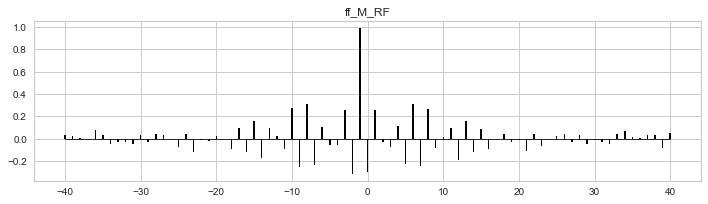

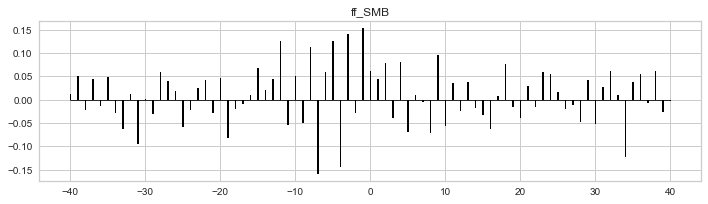

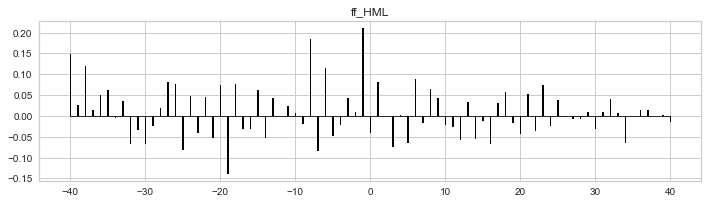

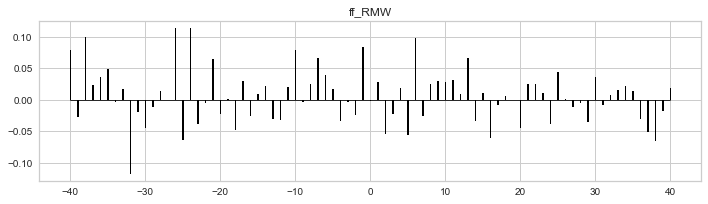

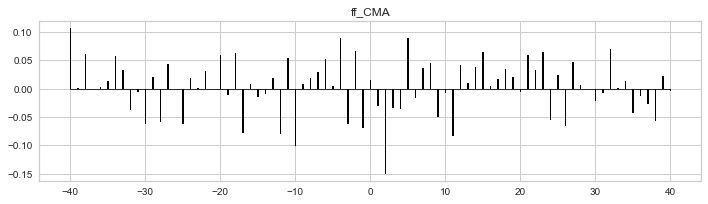

In [24]:
df_cross_corr(df_w,
              [item for item in data_dict["data"]["relevant_cols"] if item not in data_dict["data"]["sp_cols"]],
              predicted,
              show_plot=True,
              no_lags=40,
              figsize=(10, 3));

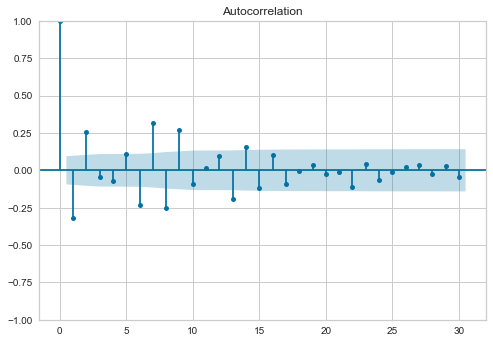

In [25]:
auto_corr(df_w.sp_close, no_lags=30, partial=False);

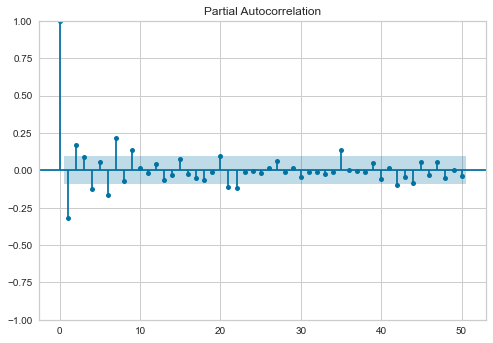

In [26]:
auto_corr(df_w.sp_close, no_lags=50, partial=True);

In [27]:
df_w, _ = shift_var_relative_to_df(df_w, "termspread", no_lags=[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15])
df_w, _ = shift_var_relative_to_df(df_w, "ff_M_RF", no_lags=[1, 2, 3, 4, 5, 6, 7, 8, 9])
df_w, _ = shift_var_relative_to_df(df_w, "vixo", no_lags=[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20])
df_w.dropna(inplace=True)

In [28]:
data_dict["data"].update(sp_cols=[item for item in df_w.columns if "sp_close" in item])

_ = list(set(data_dict['data']['relevant_cols'] + [item for item in list(df_w.columns) if "ff" in item] + 
             [item for item in list(df_w.columns) if "term" in item] + 
             [item for item in list(df_w.columns) if "vixo" in item]))
_.sort()
data_dict['data']['relevant_cols'] = _

In [29]:
data_dict['data']['relevant_cols'] 

['ff_CMA',
 'ff_HML',
 'ff_M_RF',
 'ff_M_RF_lag1',
 'ff_M_RF_lag2',
 'ff_M_RF_lag3',
 'ff_M_RF_lag4',
 'ff_M_RF_lag5',
 'ff_M_RF_lag6',
 'ff_M_RF_lag7',
 'ff_M_RF_lag8',
 'ff_M_RF_lag9',
 'ff_RF',
 'ff_RMW',
 'ff_SMB',
 'sp_close',
 'termspread',
 'termspread_lag1',
 'termspread_lag10',
 'termspread_lag11',
 'termspread_lag12',
 'termspread_lag13',
 'termspread_lag14',
 'termspread_lag15',
 'termspread_lag2',
 'termspread_lag3',
 'termspread_lag4',
 'termspread_lag5',
 'termspread_lag6',
 'termspread_lag7',
 'termspread_lag8',
 'termspread_lag9',
 'vixo',
 'vixo_lag1',
 'vixo_lag10',
 'vixo_lag11',
 'vixo_lag12',
 'vixo_lag13',
 'vixo_lag14',
 'vixo_lag15',
 'vixo_lag16',
 'vixo_lag17',
 'vixo_lag18',
 'vixo_lag19',
 'vixo_lag2',
 'vixo_lag20',
 'vixo_lag3',
 'vixo_lag4',
 'vixo_lag5',
 'vixo_lag6',
 'vixo_lag7',
 'vixo_lag8',
 'vixo_lag9']

# Feature Eng

In [30]:
df_w["weekday"] = is_day(df_w.date)

In [31]:
df_w = pd.concat([df_w,
                  pd.get_dummies(df_w.weekday).add_prefix("weekday_")],
                 axis=1)

# Saving

In [32]:
if drop_cols == ['fears25', 'fears30', 'fears35', 'goog_sent']:
    print("Saving as df_weekly_660")
    save_file(df_w, file_name="df_weekly_660.csv", file_path=WORK_DATA_DIR, index=False)
    save_file(data_dict, file_name="dict_weekly_660.pkl", file_path=WORK_DATA_DIR, index=False)
    
elif drop_cols == None:
    print("Saving as df_weekly_270")
    save_file(df_w, file_name="df_weekly_270.csv", file_path=WORK_DATA_DIR, index=False)
    save_file(data_dict, file_name="dict_weekly_270.pkl", file_path=WORK_DATA_DIR, index=False)

elif drop_cols == data_dict["data"]["df_cols"]["fears"] + data_dict["data"]["df_cols"]["goog_sent"] + data_dict["data"]["df_cols"]["put_call"]:
    print("Saving as df_weekly_760")
    save_file(df_w, file_name="df_weekly_760.csv", file_path=WORK_DATA_DIR, index=False)
    save_file(data_dict, file_name="dict_weekly_760.pkl", file_path=WORK_DATA_DIR, index=False)
    
elif drop_cols == ['fears25', 'fears30', 'fears35']:
    print("Saving as df_weekly_440")
    save_file(df_w, file_name="df_weekly_440.csv", file_path=WORK_DATA_DIR, index=False)
    save_file(data_dict, file_name="dict_weekly_440.pkl", file_path=WORK_DATA_DIR, index=False)
    
elif drop_cols == ['fears25',
                 'fears30',
                 'fears35',
                 'goog_sent',
                 'Call',
                 'Put',
                 'Total',
                 'pc_ratio',
                 'Mean/Average',
                 'naaim_max',
                 'naaim_q1',
                 'Quart 2 (median)',
                 'Quart 3 (25% at/above)',
                 'Most Bullish Response',
                 'naaim_std',
                 'naaim_ind',
                 'S&P 500']:
    print("Saving as df_weekly_1560")
    save_file(df_w, file_name="df_weekly_1560.csv", file_path=WORK_DATA_DIR, index=False)
    save_file(data_dict, file_name="dict_weekly_1560.pkl", file_path=WORK_DATA_DIR, index=False)
    
elif drop_cols == data_dict["data"]["df_cols"]["fears"] + data_dict["data"]["df_cols"]["goog_sent"] + data_dict["data"]["df_cols"]["put_call"] + data_dict["data"]["df_cols"]["naaim_risk"]:
    print("Saving as df_weekly_1560")
    save_file(df_w, file_name="df_weekly_1560.csv", file_path=WORK_DATA_DIR, index=False)
    save_file(data_dict, file_name="dict_weekly_1560.pkl", file_path=WORK_DATA_DIR, index=False)
    
elif drop_cols == data_dict["data"]["df_cols"]["fears"] + data_dict["data"]["df_cols"]["goog_sent"] + data_dict["data"]["df_cols"]["put_call"] + data_dict["data"]["df_cols"]["naaim_risk"] + data_dict["data"]["df_cols"]["aaii_bull"]: #+ data_dict["data"]["df_cols"]["cbeo_vix"] + data_dict["data"]["df_cols"]["termspread"]:
    print("Saving as df_daily_8055")
    save_file(df_w, file_name="df_daily_8055.csv", file_path=WORK_DATA_DIR, index=False)
    save_file(data_dict, file_name="dict_daily_8055.pkl", file_path=WORK_DATA_DIR, index=False)

Saving as df_daily_8055
